# Recurrent Neural Networks (without training batches)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
torch.set_printoptions(linewidth=140)

In [2]:
words = open("names.txt", "r").read().splitlines()
print(f"First few words: {words[:5]}\nNumber of words: {len(words)}")

First few words: ['emma', 'olivia', 'ava', 'isabella', 'sophia']
Number of words: 32033


In [3]:
chars = ["<S>", "<E>"] + sorted(set("".join(words)))
char_to_ix = {s: i for i, s in enumerate(chars)}
ix_to_char = {i: s for s, i in char_to_ix.items()}
vocab_size = len(chars)

In [4]:
def build_dataset(words, verbose=False):
  X, Y = [], []
  for word in words:
    word_as_list = ["<S>"] + list(word) + ["<E>"]
    word_vector = [char_to_ix[char] for char in word_as_list]
    x = word_vector[:-1]
    y = word_vector[1:]
    X.append(torch.tensor(x))
    Y.append(torch.tensor(y))
  if verbose:
    print(f"{len(X)}\t{len(Y)}")
  return X, Y

In [5]:
random.seed(5)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1], verbose=True)
X_dev, Y_dev = build_dataset(words[n1:n2], verbose=True)
X_test, Y_test = build_dataset(words[n2:], verbose=True)

25626	25626
3203	3203
3204	3204


In [6]:
for x, y in zip(X_train[:10], Y_train[:10]):
  print(f"{x.tolist()} -> {y.tolist()}")

[0, 13, 6, 25, 10, 15, 8, 21, 16, 15] -> [13, 6, 25, 10, 15, 8, 21, 16, 15, 1]
[0, 21, 10, 21, 22, 20] -> [21, 10, 21, 22, 20, 1]
[0, 6, 14, 14, 6, 21, 21] -> [6, 14, 14, 6, 21, 21, 1]
[0, 2, 13, 6, 10, 8, 9, 2] -> [2, 13, 6, 10, 8, 9, 2, 1]
[0, 5, 2, 14, 2, 19, 10, 6] -> [5, 2, 14, 2, 19, 10, 6, 1]
[0, 15, 16, 2, 4, 9] -> [15, 16, 2, 4, 9, 1]
[0, 3, 19, 10, 25, 21, 6, 15] -> [3, 19, 10, 25, 21, 6, 15, 1]
[0, 14, 2, 19, 13, 10] -> [14, 2, 19, 13, 10, 1]
[0, 2, 15, 15, 2, 3, 6, 21, 9] -> [2, 15, 15, 2, 3, 6, 21, 9, 1]
[0, 14, 2, 19, 12, 26, 13, 2] -> [14, 2, 19, 12, 26, 13, 2, 1]


In [7]:
class Embedding:
  
  def __init__(self, num_embeddings, embedding_size):
    self.C = torch.randn((num_embeddings, embedding_size)) # embedding matrix
  
  def __call__(self, IX):
    self.out = self.C[IX]
    return self.out
  
  def parameters(self):
    return [self.C]


class RNNCell:
  
  def __init__(self, input_size, output_size, hidden_size):
    self.input_size = input_size
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.W_xh = torch.randn((input_size, hidden_size)) / input_size**0.5
    self.W_hh = torch.randn((hidden_size, hidden_size)) / hidden_size**0.5
    self.b_h = torch.zeros(hidden_size)
    self.W_hy = torch.randn((hidden_size, output_size)) / hidden_size**0.5
    self.b_y = torch.zeros(output_size)
  
  def __call__(self, x, h): # x is a vector of size input size
    self.out_h = torch.tanh(x @ self.W_xh + h @ self.W_hh + self.b_h)
    self.out_y = torch.tanh(self.out_h @ self.W_hy + self.b_y).tanh()
    return self.out_h, self.out_y
  
  def parameters(self):
    return [self.W_xh, self.W_hh, self.b_h, self.W_hy, self.b_y]
  
  def init_hidden(self):
    return torch.zeros(self.hidden_size)

In [8]:
torch.manual_seed(5);

In [9]:
embedding_size = 8
hidden_size = 256

embedding = Embedding(num_embeddings=vocab_size, embedding_size=embedding_size)
rnn_cell = RNNCell(input_size=embedding_size, output_size=vocab_size, hidden_size=hidden_size)

parameters = embedding.parameters() + rnn_cell.parameters()

print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

75260


In [10]:
ix = random.randint(0, len(X_train)-1)
x_seq, y_seq = X_train[ix], Y_train[ix]

h = rnn_cell.init_hidden()
loss_seq = torch.tensor(0.)
for x, y in zip(x_seq, y_seq):
  emb = embedding(x)
  h, logits = rnn_cell(emb, h)
  loss_seq += F.cross_entropy(logits, y)
loss_seq /= len(y_seq)

print(f"{loss_seq=}")

loss_seq=tensor(3.4904, grad_fn=<DivBackward0>)


In [11]:
max_steps = 1_000_000
lossi = []

for step in range(max_steps):
  
  # select random word
  ix = random.randint(0, len(X_train)-1)
  x_seq, y_seq = X_train[ix], Y_train[ix]

  # forward pass
  h = rnn_cell.init_hidden()
  loss_seq = torch.tensor(0.)
  for x, y in zip(x_seq, y_seq):
    emb = embedding(x)
    h, logits = rnn_cell(emb, h)
    loss_seq += F.cross_entropy(logits, y)
  loss_seq /= len(y_seq)
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss_seq.backward()
  
  # update: simple SGD
  lr = 0.01 if step < 800_000 else 0.001
  for p in parameters:
    p.data += -lr * p.grad # type: ignore
  
  # track stats
  if step % 1000 == 0:
    print(f"{step}/{max_steps}\t{sum(lossi[-1000:])/1000:.4f}")
  lossi.append(loss_seq.item())

0/1000000	0.0000
1000/1000000	2.9217
2000/1000000	2.8001
3000/1000000	2.7812
4000/1000000	2.7551
5000/1000000	2.7512
6000/1000000	2.7497
7000/1000000	2.7382
8000/1000000	2.7382
9000/1000000	2.7352
10000/1000000	2.7311
11000/1000000	2.7390
12000/1000000	2.7194
13000/1000000	2.7028
14000/1000000	2.7071
15000/1000000	2.7011
16000/1000000	2.6958
17000/1000000	2.6929
18000/1000000	2.6992
19000/1000000	2.6915
20000/1000000	2.6793
21000/1000000	2.6778
22000/1000000	2.6844
23000/1000000	2.6927
24000/1000000	2.7015
25000/1000000	2.6754
26000/1000000	2.6955
27000/1000000	2.6806
28000/1000000	2.6763
29000/1000000	2.6840
30000/1000000	2.6825
31000/1000000	2.6733
32000/1000000	2.6813
33000/1000000	2.6677
34000/1000000	2.6764
35000/1000000	2.6677
36000/1000000	2.6775
37000/1000000	2.6673
38000/1000000	2.6717
39000/1000000	2.6709
40000/1000000	2.6697
41000/1000000	2.6718
42000/1000000	2.6586
43000/1000000	2.6619
44000/1000000	2.6650
45000/1000000	2.6691
46000/1000000	2.6529
47000/1000000	2.6591
48000

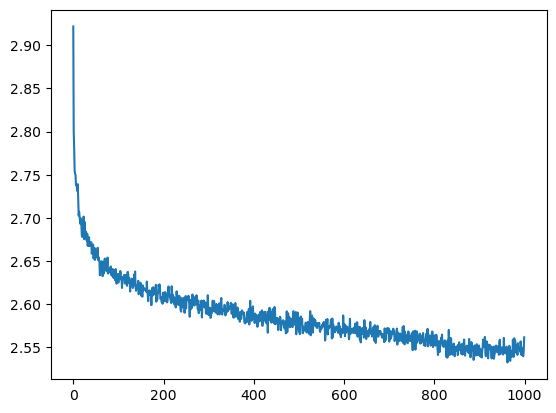

In [12]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(dim=1));

In [13]:
@torch.no_grad() # disables gradient tracking
def evaluate(X, Y):
  loss = 0
  for x_seq, y_seq in zip(X, Y):
    # forward pass
    h = rnn_cell.init_hidden()
    loss_seq = torch.tensor(0.)
    for x, y in zip(x_seq, y_seq):
      emb = embedding(x)
      h, logits = rnn_cell(emb, h)
      loss_seq += F.cross_entropy(logits, y)
    loss += loss_seq/len(y_seq)
  loss /= len(Y)
  return loss

In [14]:
print(f"Training split loss: {evaluate(X_train, Y_train):.4f}")
print(f"Development split loss: {evaluate(X_dev, Y_dev):.4f}")

Training split loss: 2.5466
Development split loss: 2.6070


Why is the loss so high?

In [15]:
print(f"Test split loss: {evaluate(X_test, Y_test):.4f}")

Test split loss: 2.6055


In [19]:
with torch.no_grad():
  g = torch.Generator().manual_seed(5)
  for start_char in chars[2:]:
    print(start_char, end="")
    h = rnn_cell.init_hidden()
    x = char_to_ix[start_char]
    out = []
    for _count in range(20):
      emb = embedding(x)
      h, logits = rnn_cell(emb, h)
      probs = F.softmax(logits, dim=0)
      # x = torch.multinomial(probs, num_samples=1, generator=g).item() # why does multinomial sampling produce gibberish?
      x = torch.argmax(probs).item()
      if x == char_to_ix["<E>"]:
        break
      char = ix_to_char[x] # type: ignore
      out.append(char)
    print("".join(out))

anielle
bantin
chinton
dielen
ellen
fanreniell
geren
hintonylee
ianasha
jan
kanielle
lenner
micaria
nshianasha
onailee
panvianaylee
qiellen
rennely
stinermaniel
tinton
ustendellen
vaniah
wannely
xyn
ykanerem
zeveren
